In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmasher as cmr
import json
import util_alex as util
import random
# from mcsc import MCSC
from guided_ig import anchored_guided_ig
import functools

%matplotlib inline
from tqdm.autonotebook import tqdm
import os
from PIL import Image

def load_image(infilename):
    img = Image.open(infilename)
    return img

# !curl -O -q https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
# with open("imagenet_classes.txt", "r") as f:
#     categories = [s.strip().split('\t') for s in f.readlines()]
#     imagenet_categories = {_[0]:_[1] for _ in categories}
#     imagenet_categories_r = {_[1]:_[0] for _ in categories}

with open("imagenet_class_index.json", "r") as f:
    categories = json.load(f)
    idx2class = {int(i):_[0] for i,_ in categories.items()}
    class2idx = {_[0]:int(i) for i,_ in categories.items()}
    class2name = {_[0]:_[1] for _ in categories.values()}
    name2class = {_[1]:_[0] for _ in categories.values()}
    
# with open("inception_classes.txt", "r") as f:
#     inception_categories = [s.strip() for s in f.readlines()]
# Show top categories per image

def categorize(probabilities, topk=5):
    top_prob, top_catid = torch.topk(probabilities, topk)
    return [
        (idx2class[top_catid[i].item()], top_prob[i].item())
        for i in range(top_prob.size(0))
    ]

# official RISE

In [2]:
import numpy as np
import torch
import torch.nn as nn
from skimage.transform import resize
from tqdm.auto import tqdm


class RISE(nn.Module):
    def __init__(self, model, input_size, batch_size=100):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.batch_size = batch_size

    def generate_masks(self, N, s, p):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float()
        self.N = N
        self.p = p

    def forward(self, x):
        N = self.N
        _, _, H, W = x.size()
        # Apply array of filters to the image
        stack = torch.mul(self.masks, x.data)
        # p = nn.Softmax(dim=1)(model(stack)) processed in batches
        prob = []
        for i in tqdm(range(0, N, self.batch_size),desc='rise'):
            prob.append(self.model(stack[i:min(i + self.batch_size, N)]))
        prob = torch.cat(prob)
        # Number of classes
        CL = prob.size(1)
        sal = torch.matmul(prob.data.transpose(0, 1), self.masks.view(N, H * W))
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p
        return sal

In [3]:
model = torchvision.models.inception_v3(pretrained=True).eval()
        
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(299),
    torchvision.transforms.CenterCrop(299),
    torchvision.transforms.ToTensor(),
])
model_norm = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Generating filters:   0%|          | 0/352 [00:00<?, ?it/s]

----------------------------------------
true:gyromitra
pred:['earthstar', 'mushroom', 'hen-of-the-woods']


rise:   0%|          | 0/44 [00:00<?, ?it/s]

why gyromitra?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

/Users/alexander.samson/code/ml/KTH/year_2/deep learning advanced/util.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(index, dtype=torch.int64)


ig:   0%|          | 0/25 [00:00<?, ?it/s]

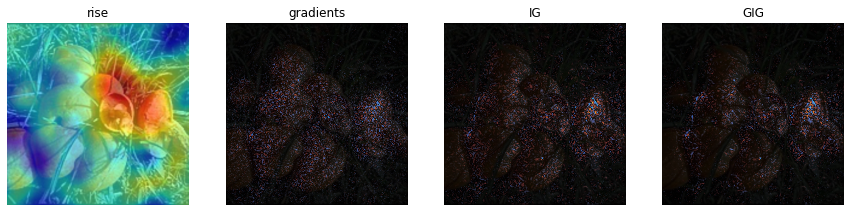

why earthstar?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

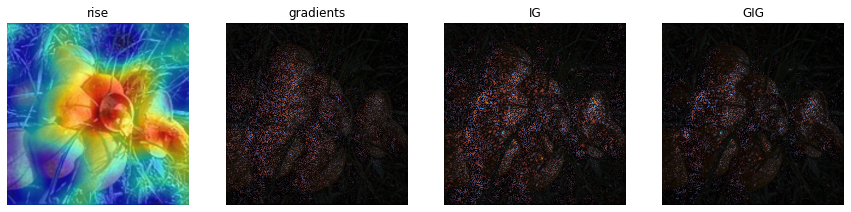

why mushroom?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

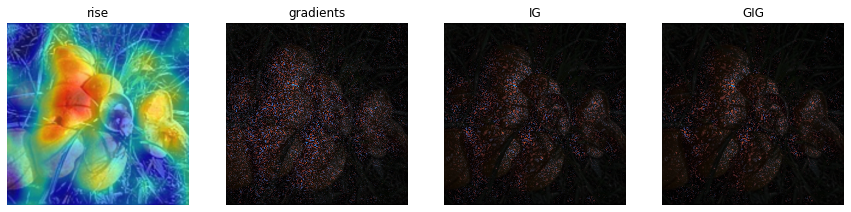

----------------------------------------
true:gyromitra
pred:['agaric', 'hen-of-the-woods', 'mushroom']


rise:   0%|          | 0/44 [00:00<?, ?it/s]

why gyromitra?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

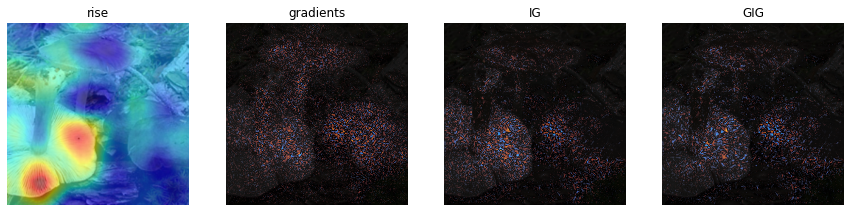

why agaric?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

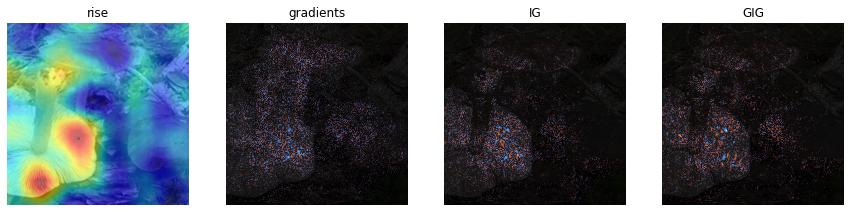

why hen-of-the-woods?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

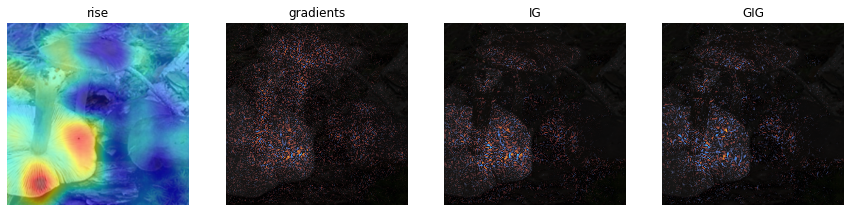

----------------------------------------
true:mosque
pred:['street_sign', 'brass', 'manhole_cover']


rise:   0%|          | 0/44 [00:00<?, ?it/s]

why mosque?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

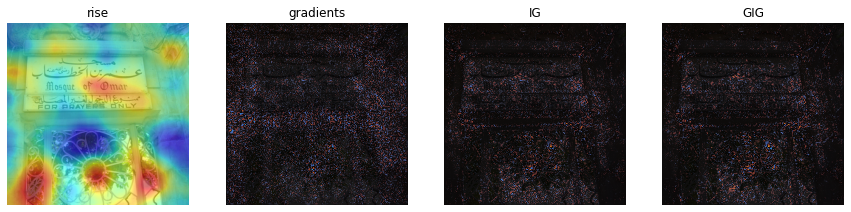

why street_sign?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

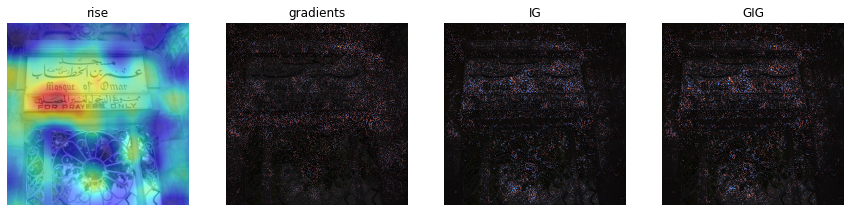

why brass?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

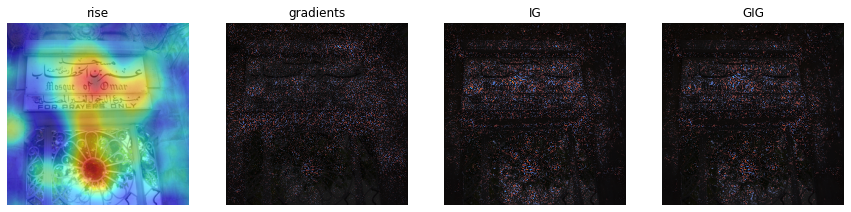

----------------------------------------
true:consomme
pred:['bottlecap', 'spindle', 'pill_bottle']


rise:   0%|          | 0/44 [00:00<?, ?it/s]

why consomme?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

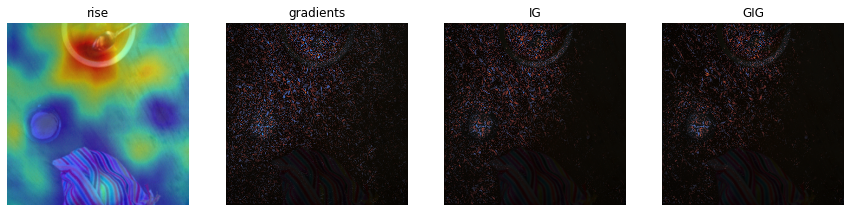

why bottlecap?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

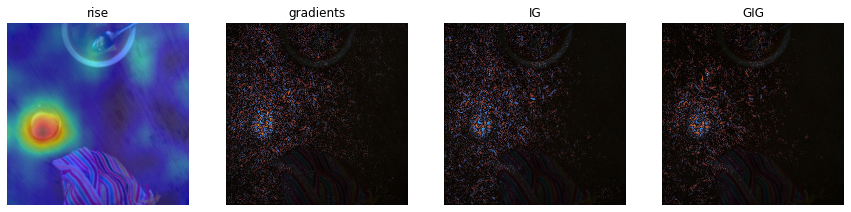

why spindle?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

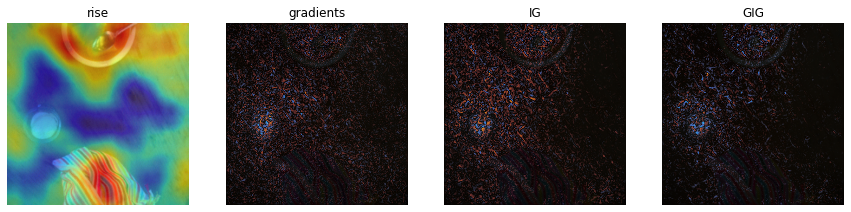

----------------------------------------
true:consomme
pred:['hot_pot', 'guacamole', 'burrito']


rise:   0%|          | 0/44 [00:00<?, ?it/s]

why consomme?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

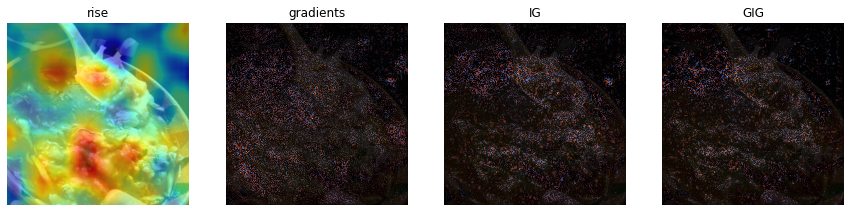

why hot_pot?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

ig:   0%|          | 0/25 [00:00<?, ?it/s]

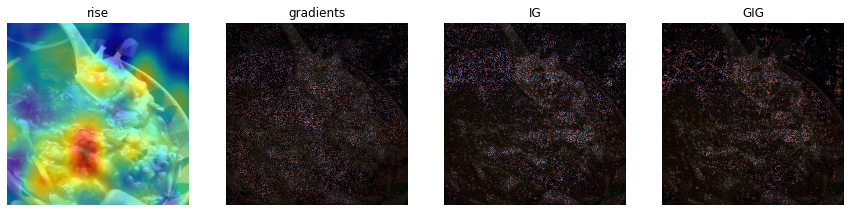

why guacamole?


gig:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
image_dir = './files/mini/'

# rise_explainer = MCSC(model,
#                 (299,299),
#                 grids=[2,3,5,8],
#                 complexity=3,
#                 multiplicity=4,
#                )

batch_size = 8

rise_explainer = RISE(model,
                      (299,299),
                      batch_size,
                     )

rise_explainer.generate_masks(16*22,8,0.1)

for i,(dirpath, dirnames, filenames) in reversed(list(enumerate(os.walk(image_dir)))):
    if i==0: continue
    for file in filenames:
        file_path = os.path.join(dirpath,file)
        image = load_image(file_path)
        
        target = {}
        target['class'] = os.path.basename(dirpath)
        target['idx'] = class2idx[target['class']]
        target['name'] = class2name[target['class']]
        
        preproccessed_input = preprocess(image)
        if preproccessed_input.shape[0]==1: continue
        normalized_input = model_norm(preproccessed_input)
        output = model(normalized_input.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        
        predicted_classes = [_[0] for _ in categorize(probabilities,topk=3)]
        predicted_names = [class2name[_] for _ in predicted_classes]
        predicted_idxs = [class2idx[_] for _ in predicted_classes]
        
        if target['class'] not in predicted_classes:
            print('-'*40)
            print(f'true:{target["name"]}\npred:{predicted_names}')
            
            
            names = [target['name']] + predicted_names[:2]
            idxs = [target['idx']] + predicted_idxs[:2]
            clss = [target['class']] + predicted_classes[:2]
            
            rise = rise_explainer(normalized_input.unsqueeze(0))
            
            for (name,cls,idx) in zip(names,clss,idxs):
                print(f'why {name}?')
                r = rise[idx]
                
                baseline = torch.zeros_like(normalized_input)
                
                model = model.eval()
                for param in model.parameters():
                    param.requires_grad = True
    
                def grad_func(x):
                    if not torch.is_tensor(x):
                        x = torch.Tensor(x)
                    return util.compute_g(model,x.unsqueeze(0),target_idx=idx).squeeze(0).numpy()
                
                steps = 200
                polarity = ''
                gig = torch.Tensor(anchored_guided_ig(normalized_input.numpy(), baseline.numpy(), grad_func, steps=steps, fraction=0.1, anchors=20))
                g = util.compute_g(model,normalized_input.unsqueeze(0),target_idx=idx).squeeze(0)
                ig = util.compute_ig(model,normalized_input.unsqueeze(0),m=steps,target_idx=idx,baseline=baseline.unsqueeze(0),batch_size=batch_size).squeeze(0)
                
                alpha = 0.9
                fig,ax = plt.subplots(1,4,figsize=(15,5))
            
                [ax[i].imshow(preproccessed_input.permute(1,2,0),alpha=0.9) for i in range(4)]
                [ax[i].axis('off') for i in range(4)]

                ax[0].imshow(r,alpha=alpha*0.6,cmap='jet')
                ax[0].set_title('rise')
                
                (g,cmap,norm) = util.vis_grad(g.permute(1,2,0),min=0.0, max=1, polarity=polarity)
                ax[1].imshow(g,cmap = cmap,norm=norm,alpha=alpha)
                (ig,cmap,norm) = util.vis_grad(ig.permute(1,2,0),min=0.0, max=1, polarity=polarity)
                ax[2].imshow(ig,cmap = cmap,norm=norm,alpha=alpha)
                (gig,cmap,norm) = util.vis_grad(gig.permute(1,2,0),min=0.0, max=1, polarity=polarity)
                ax[3].imshow(gig,cmap = cmap,norm=norm,alpha=alpha)
                
                ax[1].set_title('gradients')
                ax[2].set_title('IG')
                ax[3].set_title('GIG')
                plt.show()
preproccessed_input.backward()